In [1]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4.1-nano",
    temperature=0,
    api_key=OPENAI_API_KEY
)

In [3]:
def calculator_tool(expression: str) -> str:
    try:
        return str(eval(expression))
    except Exception as e:
        return f"Error: {e}"

In [4]:
from typing import TypedDict

class ToolAgentState(TypedDict):
    question: str
    tool_needed: bool
    tool_input: str
    tool_output: str
    answer: str

In [5]:
def decide_tool_node(state: ToolAgentState) -> ToolAgentState:
    prompt = f"""
Decide whether a tool is required to answer the question.

Question:
{state['question']}

Respond with:
TOOL: <expression>
or
NO TOOL
"""

    response = llm.invoke(prompt).content.strip()

    if response.startswith("TOOL:"):
        return {
            **state,
            "tool_needed": True,
            "tool_input": response.replace("TOOL:", "").strip()
        }

    return {
        **state,
        "tool_needed": False
    }


In [6]:
def tool_node(state: ToolAgentState) -> ToolAgentState:
    output = calculator_tool(state["tool_input"])

    return {
        **state,
        "tool_output": output
    }


In [7]:
def answer_node(state: ToolAgentState) -> ToolAgentState:
    if state["tool_needed"]:
        prompt = f"""
Use the tool result to answer the question.

Question:
{state['question']}

Tool output:
{state['tool_output']}
"""
    else:
        prompt = f"""
Answer the question directly.

Question:
{state['question']}
"""

    response = llm.invoke(prompt)

    return {
        **state,
        "answer": response.content
    }


In [8]:
def route(state: ToolAgentState) -> str:
    return "tool" if state["tool_needed"] else "answer"


In [9]:
from langgraph.graph import StateGraph, END

graph = StateGraph(ToolAgentState)

graph.add_node("decide", decide_tool_node)
graph.add_node("tool", tool_node)
graph.add_node("answer", answer_node)

graph.set_entry_point("decide")

graph.add_conditional_edges(
    "decide",
    route,
    {
        "tool": "tool",
        "answer": "answer"
    }
)

graph.add_edge("tool", "answer")
graph.add_edge("answer", END)

app = graph.compile()


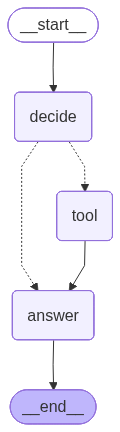

In [10]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))


In [11]:
question = "what is square root of 6"

initial_state: ToolAgentState = {
    "question": question,
    "tool_needed": False,
    "tool_input": "",
    "tool_output": "",
    "answer": ""
}

final_state = app.invoke(initial_state)

print(final_state["answer"])


The square root of 6 is approximately 2.45.
